# Importation

In [1]:
from __future__ import division  # to ensure that 1/2=0.5 and not 0 !!
import numpy as np
import scipy.constants as cst
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.style as mplstyle
import pprint as  pp 
import os
from tqdm.notebook import tqdm 

# from qutip import *
#import scqubits as scq

from Fluxonium import *

from scipy.optimize import minimize
from scipy.integrate import odeint

In [16]:
%matplotlib widget
phiq = cst.hbar/(2*cst.e)


mplstyle.use('mystyle.mplstyle')
# Define my custom color cycle
custom_colors = ["#264653", "#2a9d8f", "#8ab17d", "#f4a261", "#e9c46a", "#e76f51", "#b43718", "#264653", "#2a9d8f"]
# Set the color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)


# Define probleme

we take the master equation

$$ \frac{dP_i}{dt} = - \Sigma_j \Gamma_{i \to j} P_i + \Sigma_j \Gamma_{j \to i} P_j ~~~~~~ \forall i \in [0,N]$$

Where here $N = 2$.

We define also the link between populations and measured signal in experiment, where the IQ signal is equal : 

$$IQ(t) = \sum \limits_{i = 0, 1, 2} P_i(t) \times C_i  $$

With $C_i$ is the center of the IQ blob of the state $i$.

In [3]:
def rate_equations(p, t, Gammas):
    """
    Differential equations for the system state probabilities.
    
    Parameters:
    - p: array of probabilities for each state.
    - t: time variable (not used explicitly in the equation).
    - gamma: matrix of transition rates, where gamma[i][j] is the rate from i to j.
    
    Returns:
    - dpdt: array of derivatives of probabilities.
    """
    n = len(p)  # Number of states
    dpdt = np.zeros(n)
    for i in range(n):
        dpdt[i] = -np.sum(Gammas[i,:]) * p[i] + np.sum(Gammas[:,i] * p)
    return dpdt


def solve_population_dynamics(gamma, p0, times):
    """
    Solves the differential equations for a given gamma matrix and initial state.
    
    Parameters:
    - gamma: 3x3 numpy array with transition rates.
    - p0: Initial state probabilities as a list.
    - times: Array of time points at which to solve the differential equations.
    
    Returns:
    - p: Array of probabilities over time for each state.
    """
    p = odeint(rate_equations, p0, times, args=(gamma,))
    return p

def population_to_signal(p, centres):
    """
    Convert population vector to IQ signal based on state centres.
    
    Parameters:
    - p: array of population probabilities at a specific time.
    - centres: array of complex numbers representing the IQ blob centers for each state.
    
    Returns:
    - IQ signal as a complex number.
    """
    return np.sum([p[i] * centres[i] for i in range(len(centres))], axis = 0)

def compute_theoretical_signal(gamma, p0, times, centres):
    gamma_matrix = np.array(gamma).reshape((3, 3))
    p = odeint(rate_equations, p0, times, args=(gamma_matrix,))
    iq_signals = population_to_signal(p.T, centres)
    return iq_signals

def objective(gamma, measured_signal, times, p0, centres):
    theoretical_signal = compute_theoretical_signal(gamma, p0, times, centres)
    return np.sum(np.abs(theoretical_signal - measured_signal)**2)


# Fitting example

In [4]:
""""""""" example

# Define bounds, setting some transitions rates to zero
bounds = [
    (0, 0),     # Gamma_{0 -> 0}
    (0, None),  # Gamma_{0 -> 1}
    (0, None),  # Gamma_{0 -> 2}
    (0, None),  # Gamma_{1 -> 0}
    (0, 0),     # Gamma_{1 -> 1}
    (0, None),  # Gamma_{1 -> 2}
    (0, None),  # Gamma_{2 -> 0}
    (0, None),  # Gamma_{2 -> 1}
    (0, 0)      # Gamma_{2 -> 2}
]


times = np.linspace(0, 10, 100)  # Same times as experiment
measured_signal = np.random.randn(100) + 1j*np.random.randn(100)  # Placeholder for actual measured data
p0 = [1, 0, 0]  # Starting in state 0
centres = [complex(1, 0), complex(0, 1), complex(-1, 0)]  # Example centers


# Initial guess for gamma 
initial_gamma = np.array([0, 0, 0, 0.1, 0, 0.2, 0, 0.1, 0.1])

# Perform the optimization
result = minimize(
    objective,
    initial_gamma,
    args=(measured_signal, times, p0, centres),
    method='L-BFGS-B',
    bounds=bounds  # Apply bounds
)


if result.success:
    fitted_gamma = result.x.reshape((3, 3))
    print("Fitted Gamma Matrix:\n", fitted_gamma)
else:
    print("Optimization failed:", result.message)


"""""""""

' example\n\n# Define bounds, setting some transitions rates to zero\nbounds = [\n    (0, 0),     # Gamma_{0 -> 0}\n    (0, None),  # Gamma_{0 -> 1}\n    (0, None),  # Gamma_{0 -> 2}\n    (0, None),  # Gamma_{1 -> 0}\n    (0, 0),     # Gamma_{1 -> 1}\n    (0, None),  # Gamma_{1 -> 2}\n    (0, None),  # Gamma_{2 -> 0}\n    (0, None),  # Gamma_{2 -> 1}\n    (0, 0)      # Gamma_{2 -> 2}\n]\n\n\ntimes = np.linspace(0, 10, 100)  # Same times as experiment\nmeasured_signal = np.random.randn(100) + 1j*np.random.randn(100)  # Placeholder for actual measured data\np0 = [1, 0, 0]  # Starting in state 0\ncentres = [complex(1, 0), complex(0, 1), complex(-1, 0)]  # Example centers\n\n\n# Initial guess for gamma \ninitial_gamma = np.array([0, 0, 0, 0.1, 0, 0.2, 0, 0.1, 0.1])\n\n# Perform the optimization\nresult = minimize(\n    objective,\n    initial_gamma,\n    args=(measured_signal, times, p0, centres),\n    method=\'L-BFGS-B\',\n    bounds=bounds  # Apply bounds\n)\n\n\nif result.success:\n    

# Example case

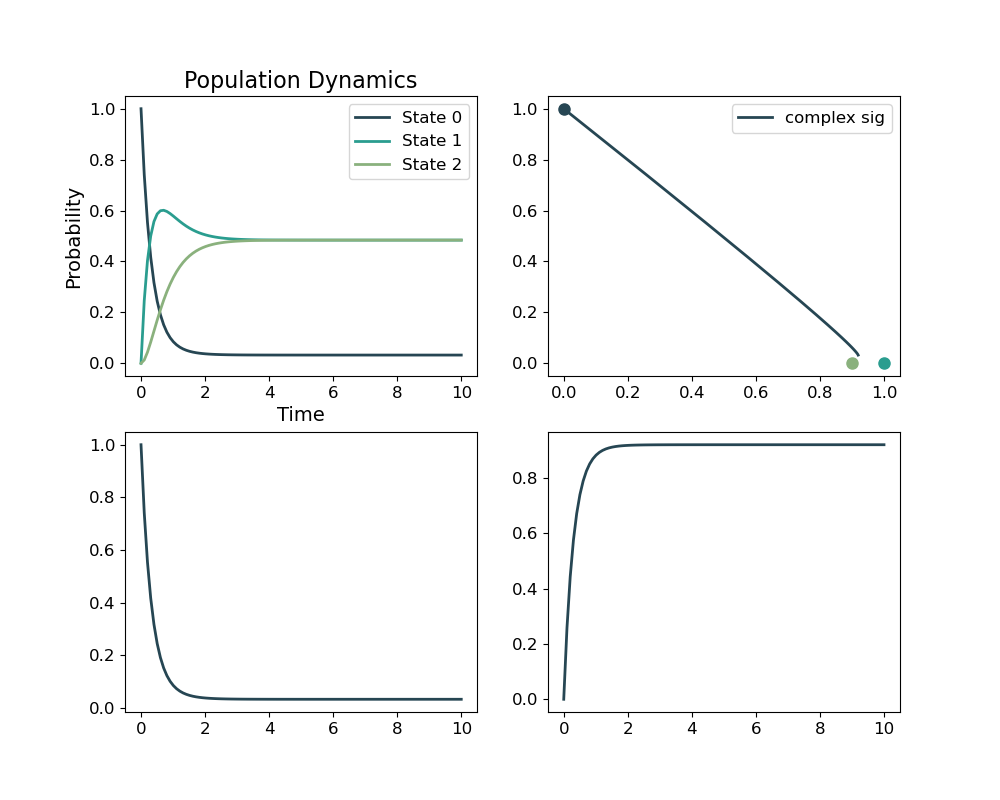

In [5]:
# Example usage:
# Define transition rates and initial state for a system with N=2 (3 states)

gamma = np.array([[0,   3,  0 ],
                  [0.2, 0,  1 ],
                  [0,   1,  0 ]])

p0 = [1, 0, 0]  # Starting in state 0

centres = [complex(1, 0), complex(0, 1), complex(0, 0.9)]  # Example centers

times = np.linspace(0, 10, 100)

# Solve the population dynamics

p = solve_population_dynamics(gamma, p0, times)

fig, (axs1, axs2) = plt.subplots(2, 2, figsize=(10, 8))

# Plotting the results
axs1[0].plot(times, p[:,0], label='State 0')
axs1[0].plot(times, p[:,1], label='State 1')
axs1[0].plot(times, p[:,2], label='State 2')
axs1[0].set_xlabel('Time')
axs1[0].set_ylabel('Probability')
axs1[0].set_title('Population Dynamics')
axs1[0].legend()

axs1[1].plot(np.imag(population_to_signal(p.T, centres)),np.real(population_to_signal(p.T, centres)), label='complex sig')

axs1[1].scatter(np.imag(centres[0]), np.real(centres[0]))
axs1[1].scatter(np.imag(centres[1]), np.real(centres[1]))
axs1[1].scatter(np.imag(centres[2]), np.real(centres[2]))

axs1[1].legend()


axs2[0].plot(times,np.real(population_to_signal(p.T, centres)), label='Real I')
axs2[1].plot(times,np.imag(population_to_signal(p.T, centres)), label='Imag Q')


# Fit 

In [6]:
data_T1_paper = 1e3*np.array([5.72092873e-05-0.00012445j, 8.17025201e-05-0.00013161j,
       1.02520661e-04-0.0001385j , 1.21335315e-04-0.00014397j,
       1.36056982e-04-0.00014868j, 1.50033468e-04-0.00015307j,
       1.64387427e-04-0.00015778j, 1.75919921e-04-0.00016127j,
       1.86432662e-04-0.00016501j, 1.98471306e-04-0.0001687j ,
       2.09459825e-04-0.00017286j, 2.16321847e-04-0.00017426j,
       2.25233297e-04-0.0001772j , 2.32424853e-04-0.00017933j,
       2.37293919e-04-0.00018078j, 2.47396813e-04-0.00018406j,
       2.53692863e-04-0.00018547j, 2.63482495e-04-0.00018917j,
       2.66070427e-04-0.00018967j, 2.72794539e-04-0.00019217j,
       2.78952833e-04-0.00019439j, 2.85985248e-04-0.00019636j,
       2.89151954e-04-0.000197j  , 2.92000834e-04-0.00019868j,
       2.95645799e-04-0.0001992j , 3.02560029e-04-0.00020156j,
       3.03572060e-04-0.00020234j, 3.07651431e-04-0.00020368j,
       3.11806787e-04-0.0002045j , 3.14992374e-04-0.00020584j,
       3.15707438e-04-0.00020576j, 3.21033395e-04-0.00020807j,
       3.23258359e-04-0.00020872j, 3.28656469e-04-0.00021144j,
       3.30087924e-04-0.00021145j, 3.32419394e-04-0.00021256j,
       3.35105895e-04-0.00021284j, 3.36131255e-04-0.00021323j,
       3.38420819e-04-0.00021342j, 3.42414893e-04-0.00021568j,
       3.45103270e-04-0.00021566j, 3.46774178e-04-0.00021673j,
       3.50016289e-04-0.00021828j, 3.51142064e-04-0.00021859j,
       3.53300354e-04-0.00021872j, 3.56686659e-04-0.00021999j,
       3.57445883e-04-0.00022063j, 3.59495999e-04-0.0002219j ,
       3.60864552e-04-0.00022212j, 3.62905688e-04-0.00022217j,
       3.65132701e-04-0.00022364j])

time_vec_data = np.array([  0. ,  10.2,  20.4,  30.6,  40.8,  51. ,  61.2,  71.4,  81.6,
         91.8, 102. , 112.2, 122.4, 132.6, 142.8, 153. , 163.2, 173.4,
        183.6, 193.8, 204. , 214.2, 224.4, 234.6, 244.8, 255. , 265.2,
        275.4, 285.6, 295.8, 306. , 316.2, 326.4, 336.6, 346.8, 357. ,
        367.2, 377.4, 387.6, 397.8, 408. , 418.2, 428.4, 438.6, 448.8,
        459. , 469.2, 479.4, 489.6, 499.8, 510. ]) # in mus

In [17]:
""""""""" example
"""""""""
# Define bounds, setting some transitions rates to zero
bounds = [
    (0, 0),     # Gamma_{0 -> 0}
    (0, None),  # Gamma_{0 -> 1}
    (0, 0),  # Gamma_{0 -> 2}
    (0, None),  # Gamma_{1 -> 0}
    (0, 0),     # Gamma_{1 -> 1}
    (0, None),  # Gamma_{1 -> 2}
    (0, 0),  # Gamma_{2 -> 0}
    (0, None),  # Gamma_{2 -> 1}
    (0, 0)      # Gamma_{2 -> 2}
]


times = time_vec_data  # Same times as experiment
measured_signal = data_T1_paper # Placeholder for actual measured data
p0 = [0.1, 0.8, 0.1]  # Starting in state 0
centres = [complex(0.3656, -0.223), complex(0.06, -0.125), complex(0.06, -0.125)]  # Example centers


# Initial guess for gamma 
initial_gamma = np.array([0, 0, 0, 0.005, 0, 0.0005, 0, 0, 0])

# Perform the optimization
result = minimize(
    objective,
    initial_gamma,
    args=(measured_signal, times, p0, centres),
    method='L-BFGS-B',
    bounds=bounds  # Apply bounds
)


if result.success:
    fitted_gamma = result.x.reshape((3, 3))
    print("Fitted Gamma Matrix:\n", fitted_gamma)
else:
    print("Optimization failed:", result.message)




Fitted Gamma Matrix:
 [[0.         0.         0.        ]
 [0.00597202 0.         0.        ]
 [0.         0.01491212 0.        ]]


In [8]:
fitted_gamma**-1

C:\Users\wael\AppData\Local\Temp\ipykernel_40912\2502925366.py:1: RuntimeWarning: divide by zero encountered in reciprocal
  fitted_gamma**-1


array([[         inf,          inf,          inf],
       [167.44758815,          inf,          inf],
       [         inf,  67.05956016,          inf]])

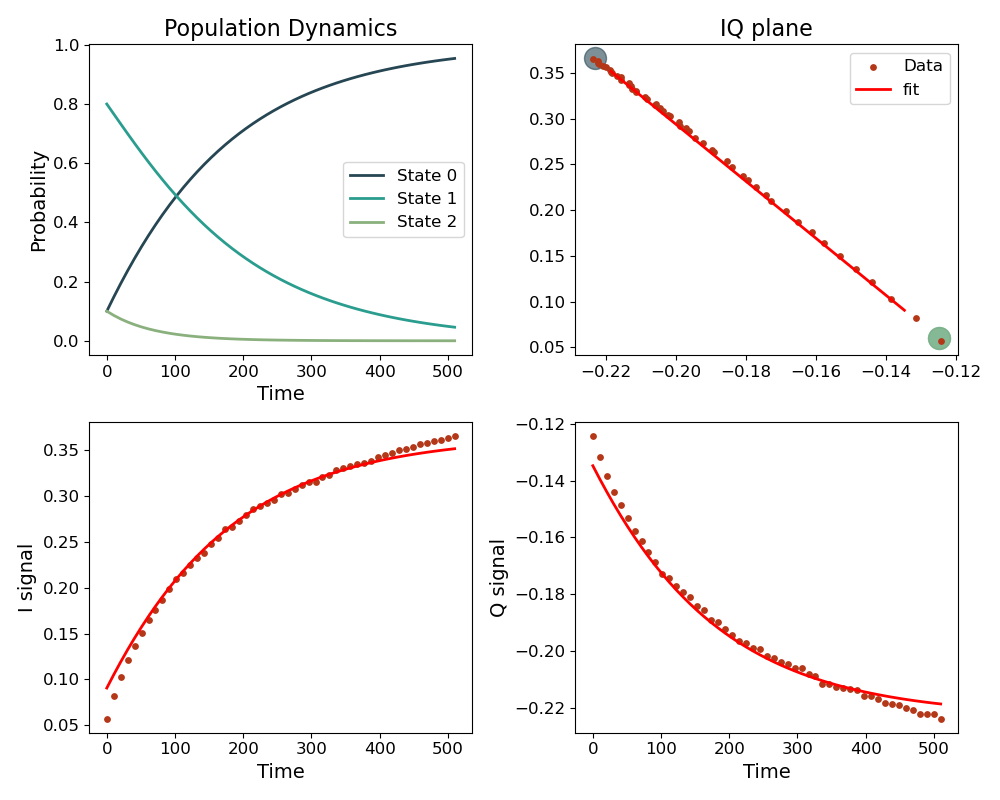

In [34]:
p = solve_population_dynamics(fitted_gamma, p0, times)

fig, (axs1, axs2) = plt.subplots(2, 2, figsize=(10, 8))

# Plotting the results
axs1[0].plot(times, p[:,0], label='State 0')
axs1[0].plot(times, p[:,1], label='State 1')
axs1[0].plot(times, p[:,2], label='State 2')

axs1[0].set_xlabel('Time')
axs1[0].set_ylabel('Probability')
axs1[0].set_title('Population Dynamics')
axs1[0].legend()



axs1[1].scatter(np.imag(centres[0]), np.real(centres[0]), s = 250, alpha = 0.6)
axs1[1].scatter(np.imag(centres[1]), np.real(centres[1]), s = 250, alpha = 0.6)
axs1[1].scatter(np.imag(centres[2]), np.real(centres[2]), s = 250, alpha = 0.6)


axs1[1].scatter(np.imag(data_T1_paper),np.real(data_T1_paper), label='Data', s = 15, color = custom_colors[-3] )
axs1[1].plot(np.imag(population_to_signal(p.T, centres)),np.real(population_to_signal(p.T, centres)), 'r',label='fit')

axs1[1].set_title('IQ plane')


axs1[1].legend()


axs2[0].plot(times,np.real(population_to_signal(p.T, centres)), 'r', label='Real I')

axs2[0].scatter(times,np.real(data_T1_paper), label='Data', s = 15,color = custom_colors[-3])

axs2[1].plot(times,np.imag(population_to_signal(p.T, centres)), 'r', label='Imag Q')
axs2[1].scatter(times,np.imag(data_T1_paper), label='Data', s = 15,color = custom_colors[-3])

axs2[1].set_ylabel('Q signal')
axs2[0].set_ylabel('I signal')

axs2[1].set_xlabel('Time')
axs2[0].set_xlabel('Time')

fig.tight_layout()